In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import bson
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import shap
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
processed_data_path = "/Users/sakshamarora/Documents/6748 Practicum/processed_data"

In [3]:
merged_df_with_2P = pd.read_csv('../../../processed_data/Women_merged_df_with_2P.csv')

In [4]:
print(merged_df_with_2P['Fastbreak'].mean())
merged_df_with_2P['Fastbreak'].count()

0.06383444455612512


447705

In [5]:
# Function to clean column names
def clean_column_names(df):
    df.columns = df.columns.str.replace('[{}:,"]', '', regex=True)  # Replace special JSON characters
    df.columns = df.columns.str.replace(' ', '_')  # Replace spaces with underscores
    return df

# Select features for the model
X = merged_df_with_2P.drop([
    'game_id', 'team_id', 'team_id', 'season_id', 'player_id', 'shot_id', 'segment_id', 'date', 
    'has_locations', 'has_segments', 'team1', 'team2', 'hometeam', 'Made', 'Time', 'Stat', 'season', 
    'league', 'score','winning_team', 'score_opp', 'And1', 'Blocked', 'Assisted','Unnamed: 0'
], axis=1)

# Clean column names
X = clean_column_names(X)

# Define categorical features
categorical_features = ['Location', 'Zone', 'Period', 'LBA_position', 'year', 'Shot_type'] 

# Convert categorical columns to 'category' type
for col in categorical_features:
    if col in X.columns:  # Check if the column exists in the DataFrame
        X[col] = X[col].astype('category')

# Define the target variable
y = merged_df_with_2P['Made']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Recursive Feature Elimination

In [7]:
feature_list = X_train.columns.to_numpy()
num_features_list = []
actual_features_list = []
train_auc_score_list = []
test_auc_score_list = []
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the model
num_round = 100
step_size = 1
while len(feature_list)>2:
    if len(feature_list)>=200:
        step_size=30
    elif (len(feature_list)>=100) & (len(feature_list)<200):
        step_size=15
    elif (len(feature_list)>=50) & (len(feature_list)<100):
        step_size=10
    elif (len(feature_list)>=20) & (len(feature_list)<50):
            step_size=3
    elif (len(feature_list)>=1) & (len(feature_list)<20):
            step_size=1
            

    categorical_features = list(set(categorical_features).intersection(set(feature_list)))
    train_data = lgb.Dataset(X_train[feature_list], label=y_train, categorical_feature=categorical_features)
    test_data = lgb.Dataset(X_test[feature_list], label=y_test, categorical_feature=categorical_features)
    bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])
    y_train_pred = bst.predict(X_train[feature_list], num_iteration=bst.best_iteration)
    y_test_pred = bst.predict(X_test[feature_list], num_iteration=bst.best_iteration)
    num_features_list.append(str(len(feature_list)))
    actual_features_list.append(feature_list)    
    train_auc_score_list.append(roc_auc_score(y_train, y_train_pred))
    test_auc_score_list.append(roc_auc_score(y_test, y_test_pred))
    ini_len = len(feature_list)
    feature_list = feature_list[bst.feature_importance(importance_type='gain').argsort()[::-1]][:-step_size]

[LightGBM] [Info] Number of positive: 161133, number of negative: 197031
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14225
[LightGBM] [Info] Number of data points in the train set: 358164, number of used features: 124
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.449886 -> initscore=-0.201131
[LightGBM] [Info] Start training from score -0.201131
[LightGBM] [Info] Number of positive: 161133, number of negative: 197031
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13980
[LightGBM] [Info] Number of data points in the train set: 358164, number of used features: 109
[LightGB

In [8]:
num_features_list#,train_auc_score_list)


['124',
 '109',
 '94',
 '84',
 '74',
 '64',
 '54',
 '44',
 '41',
 '38',
 '35',
 '32',
 '29',
 '26',
 '23',
 '20',
 '17',
 '16',
 '15',
 '14',
 '13',
 '12',
 '11',
 '10',
 '9',
 '8',
 '7',
 '6',
 '5',
 '4',
 '3']

Text(0, 0.5, 'AUC Score')

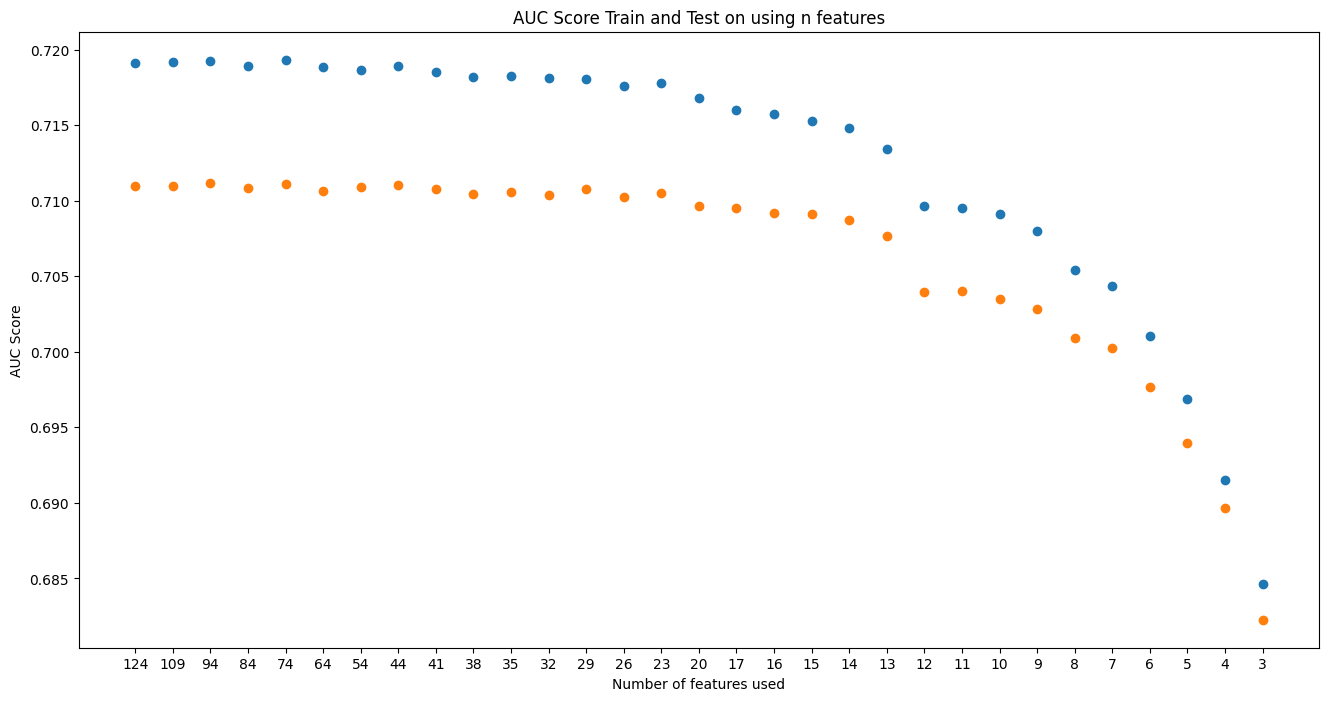

In [9]:
fig,ax = plt.subplots(1,1,figsize=(16,8))
ax.scatter(num_features_list,train_auc_score_list)
ax.scatter(num_features_list,test_auc_score_list)
plt.title("AUC Score Train and Test on using n features")
plt.xlabel("Number of features used")
plt.ylabel("AUC Score")

In [10]:
wanted_features = 26
num_features_list = np.array(num_features_list) 
feature_list = X_train.columns.to_numpy()
actual_features_list[np.argwhere(num_features_list==str(wanted_features))[0][0]]

array(['Fastbreak', 'Distance', 'Jumpshot', 'Red_Zone', 'height',
       'Off_Steal', 'Drive', 'Shot_type', 'TOT_Shot_type_perc%',
       'clutch_time', 'Zone', 'TOT_2P%', 'TOT_Zone_made',
       'Last_season_2P%', 'score_pre_shot_diff',
       'opp_team_wl_ratio_prev_season', 'Last_season_Shot_type_perc%',
       'Last_season_Jumpshots_assisted_on', 'Big',
       'team_wl_ratio_prev_season', 'L10_2P%', 'score_pre_shot',
       'Time_Seconds', 'TOT_Shot_type_made', 'opp_w_l_ratio_last_10',
       'TOT_Jumpshots_assisted_on'], dtype=object)

## Permutation Importance Full model

In [10]:
feature_list = ['Fastbreak', 'Distance', 'Jumpshot', 'Dunk', 'Red Zone',
       'Off Steal', 'Zone', 'height', 'Drive', 'Layup',
       'opp_w_l_ratio_last_1', 'TOT 2P%', 'w_l_ratio_last_1',
       'x_coordinate', 'Time_Seconds', 'TOT Hook Shots made',
       'TOT Layup FG%', 'Angle', 'TOT Jumpshots made', 'Big',
       'opp_w_l_ratio_last_10', 'Hook Shot', 'TOT 1 attempted',
       'L10 Jumpshots made', 'L10 Layup FG%']
categorical_features = list(set(categorical_features).intersection(set(feature_list)))
categorical_features

[]

In [11]:
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the model
num_round = 100
train_data = lgb.Dataset(X_train[feature_list], label=y_train, categorical_feature=categorical_features)
test_data = lgb.Dataset(X_test[feature_list], label=y_test, categorical_feature=categorical_features)
full_model_bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])
full_model_y_train_pred = full_model_bst.predict(X_train[feature_list], num_iteration=full_model_bst.best_iteration)
full_model_y_test_pred = full_model_bst.predict(X_test[feature_list], num_iteration=full_model_bst.best_iteration)
full_model_train_roc_auc = roc_auc_score(y_train,full_model_y_train_pred)
full_model_test_roc_auc = roc_auc_score(y_test,full_model_y_test_pred)
full_model_train_roc_auc,full_model_test_roc_auc

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 153427, number of negative: 152002
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2141
[LightGBM] [Info] Number of data points in the train set: 305429, number of used features: 25
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502333 -> initscore=0.009331
[LightGBM] [Info] Start training from score 0.009331


(0.729625872238169, 0.7208038796969727)

In [12]:
full_model_y_test_pred.mean()

0.5008418654894606

## Permutation Feature Importance

In [13]:
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}
# Train the model
num_round = 100

feature_importances = {}
features_list = feature_list
train_auc_score_list = np.zeros(len(feature_list))
test_auc_score_list = np.zeros(len(feature_list))

n_repeats = 3
for feature in features_list:            
    print(f"# On Feature :{feature}")
    corrupted_X_train_scores = np.zeros(n_repeats)
    corrupted_X_test_scores = np.zeros(n_repeats)

    for repeat in range(n_repeats):
        print(f"## On Repeat number :{repeat}")
        corrupted_X_train = X_train[features_list].copy()
        corrupted_X_test = X_test[features_list].copy()
        np.random.shuffle(corrupted_X_train[feature].to_numpy())
        np.random.shuffle(corrupted_X_test[feature].to_numpy())
        corrupted_y_train_pred = full_model_bst.predict(corrupted_X_train, num_iteration=full_model_bst.best_iteration)
        corrupted_y_test_pred = full_model_bst.predict(corrupted_X_test, num_iteration=full_model_bst.best_iteration)
        # del(corrupted_X_train)
        # del(corrupted_X_test)
        corrupted_X_train_scores[repeat] = (roc_auc_score(y_train, corrupted_y_train_pred))
        corrupted_X_test_scores[repeat] = (roc_auc_score(y_test, corrupted_y_test_pred))
    feature_importance_train_mean = (full_model_train_roc_auc - corrupted_X_train_scores).mean()
    feature_importance_train_sd = (full_model_train_roc_auc - corrupted_X_train_scores).std()
    feature_importance_test_mean = (full_model_test_roc_auc - corrupted_X_test_scores).mean()
    feature_importance_test_sd = (full_model_test_roc_auc - corrupted_X_test_scores).std()
    feature_importances[feature] = [(feature_importance_train_mean,feature_importance_train_sd),(feature_importance_test_mean,feature_importance_test_sd)]


# On Feature :Fastbreak
## On Repeat number :0
## On Repeat number :1
## On Repeat number :2
# On Feature :Distance
## On Repeat number :0
## On Repeat number :1
## On Repeat number :2
# On Feature :Jumpshot
## On Repeat number :0
## On Repeat number :1
## On Repeat number :2
# On Feature :Dunk
## On Repeat number :0
## On Repeat number :1
## On Repeat number :2
# On Feature :Red Zone
## On Repeat number :0
## On Repeat number :1
## On Repeat number :2
# On Feature :Off Steal
## On Repeat number :0
## On Repeat number :1
## On Repeat number :2
# On Feature :Zone
## On Repeat number :0
## On Repeat number :1
## On Repeat number :2
# On Feature :height
## On Repeat number :0
## On Repeat number :1
## On Repeat number :2
# On Feature :Drive
## On Repeat number :0
## On Repeat number :1
## On Repeat number :2
# On Feature :Layup
## On Repeat number :0
## On Repeat number :1
## On Repeat number :2
# On Feature :opp_w_l_ratio_last_1
## On Repeat number :0
## On Repeat number :1
## On Repeat 

In [14]:
train_means = np.zeros(len(feature_importances.keys()))
train_lower_bnd = np.zeros(len(feature_importances.keys()))
train_upper_bnd = np.zeros(len(feature_importances.keys()))
features = np.array(feature_list)
for index,(feature,values) in enumerate(feature_importances.items()):
    train_means[index] = values[0][0]
    train_lower_bnd[index] = values[0][0]-values[0][1]
    train_upper_bnd[index] = values[0][0]+values[0][1]

<Axes: >

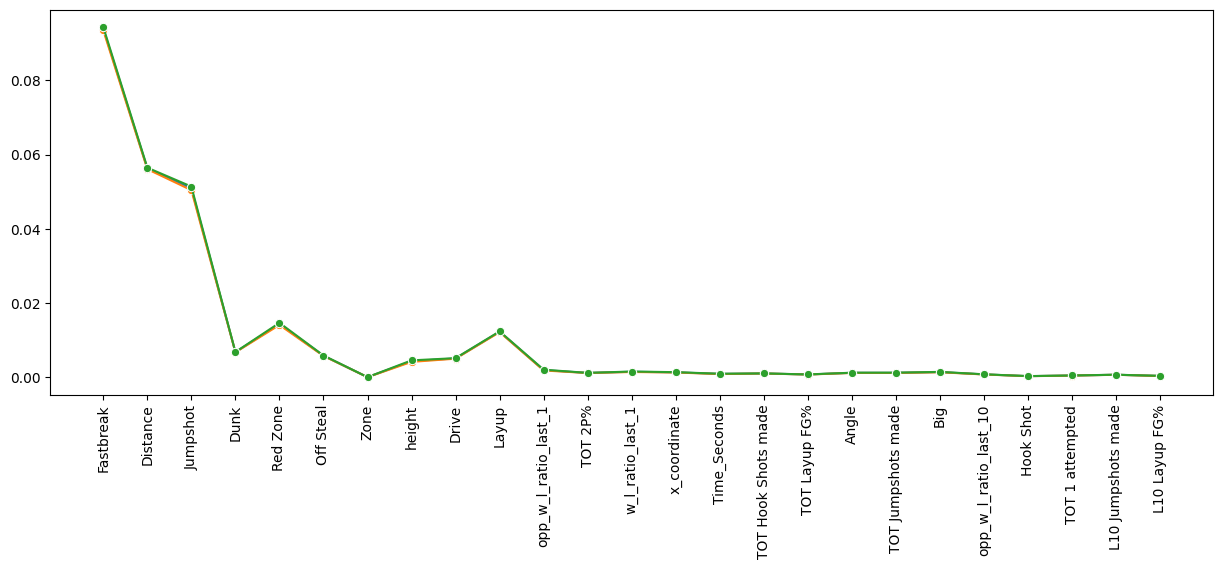

In [15]:
fig,ax= plt.subplots(figsize=(15,5))
ax.tick_params(axis='x',labelrotation=90)
sns.lineplot(x=features,y=train_means,ax=ax,marker='o')    
sns.lineplot(x=features,y=train_lower_bnd,ax=ax,marker='o')    
sns.lineplot(x=features,y=train_upper_bnd,ax=ax,marker='o')    

In [16]:
roc_auc_score(y_test, corrupted_y_test_pred), roc_auc_score(y_train,full_model_y_train_pred)

(0.7207090138277841, 0.729625872238169)

In [17]:
feature_importances['Fastbreak']

[(0.0939012333540306, 0.0004331155188463367),
 (0.09128912280370165, 0.0006727108246602072)]

In [18]:
explainer = shap.TreeExplainer(full_model_bst)
shap_values = explainer.shap_values(X_train[feature_list])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


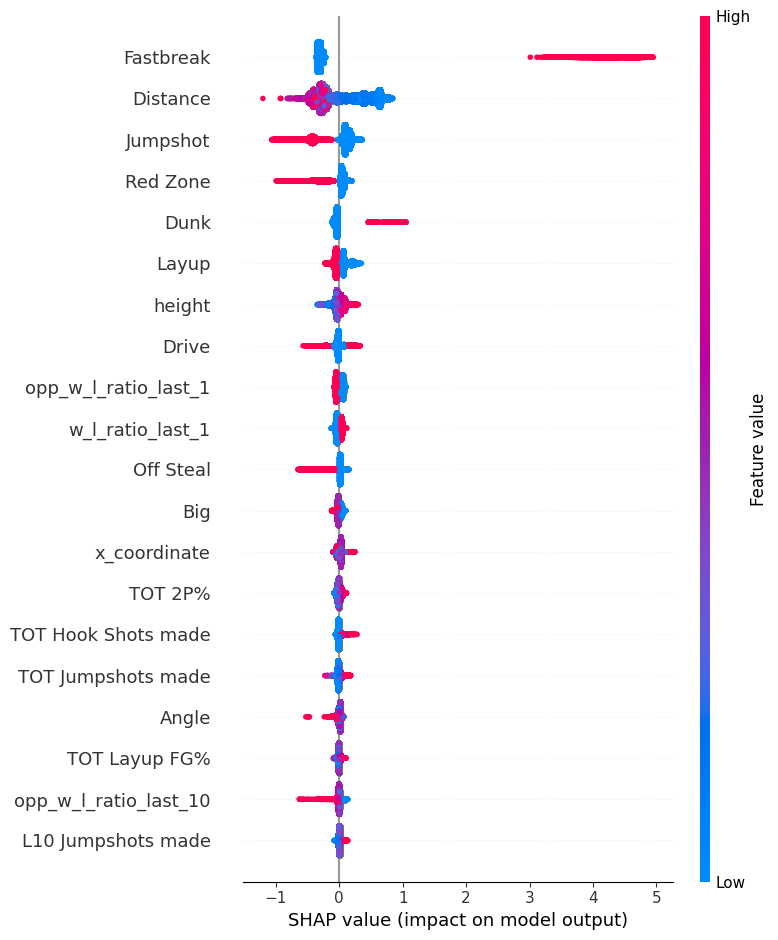

In [19]:
shap.summary_plot(shap_values[1], X_train[feature_list], plot_type='dot')